In [1]:
import matplotlib.pyplot as plt
from atcoder import *

In [2]:
from database import Database, LoadDatabase
import numpy as np

# TODO:
#   - add parameters - for now make sure it is correct
#   - maybe add standarized method for calculating error rate - needs to be discussed
#     with others

# return value: ans, userRatings
#   ans - dict of contestId: average error on expected ranking
#   userRatings: dict of handle: inner rating class with AtCoder specific measures
# parameters:
#   - consider: eg. consider=50, will consider only 50 first contests
#   - verbose: print verbosely
def AtCoderRatingSystem(data, consider=50, verbose=False, **kwargs):
    CENTER = 1200
    RATEDBOUND = np.inf

    def powersum(q, n):
        return q * (1 - q**n) / (1 - q)

    def F(n):
        return np.sqrt(powersum(0.81, n)) / powersum(0.9, n)

    def f(n):
        Finf = np.sqrt(0.81 / (1.0 - 0.81)) / (0.9 / (1.0 - 0.9))
        return (F(n) - Finf) / (F(1) - Finf) * CENTER

    def g(x):
        return 2.0 ** (x / 800.0)

    def ginv(y):
        return 800 * np.log2(y)

    class Rating:
        def __init__(self):
            self.perfs = []
            self.num = 0
            self.den = 0
            self.aperf = 0
            self.ratings = []

        def getAPerf(self):
            return self.aperf if len(self.perfs) > 0 else CENTER

        def addPerf(self, perf):
            self.ratings.append(self.getRating())
            if len(self.perfs) == 0:
                perf = (perf - CENTER) * 1.5 + CENTER
            self.perfs.append(perf)
            self.num = 0.9 * (perf + self.num)
            self.den = 0.9 * (1 + self.den)
            self.aperf = self.num / self.den
        
        def getRating(self):
            if len(self.perfs) == 0:
                return 0

            res = 0
            mult = 1
            for perf in self.perfs:
                rperf = self.getRPerf(perf)
                mult *= 0.9
                res += g(rperf) * mult
            return ginv(res / self.den) - f(len(self.perfs))

        def getRPerf(self, perf):
            return min(perf, RATEDBOUND + 400)

    userRatings = {}

    def addNewUsers(standings):
        for handle in standings.index:
            if not handle in userRatings:
                userRatings[handle] = Rating()

    def getRatings(standings):
        return [(handle, userRatings[handle].getRating()) for handle in standings.index]

    def calcExpectedRanksFromRatings(ratings):
        sortedRatings = sorted(ratings, key=lambda x: -x[1])
        ranks = np.empty(len(sortedRatings))
        i = 0
        while i < len(ranks):
            j = i
            rating = sortedRatings[i][1]
            while j + 1 < len(ranks) and sortedRatings[j + 1][1] == rating:
                j += 1
            ranks[i:j+1] = (i + 1 + j + 1) / 2
            i = j + 1
        return [(handle, ranks[i]) for i, (handle, _) in enumerate(sortedRatings)]

    def calcErrorRate(expectedRanks, standings):
        res = 0.0
        for handle, rank in expectedRanks:
            res += np.sqrt(abs(rank - standings.loc[handle]["rank"]))
        return res / len(expectedRanks)

    def fixRanks(ranks):
        newRanks = np.empty(len(ranks))
        i = 0
        while i < slen:
            j = i
            curRank = ranks[i]
            while j + 1 < slen and ranks[j + 1] == curRank:
                j += 1
            n = j - i + 1
            first = curRank
            last = curRank + n - 1
            newRanks[i:j+1] = (first + last) / 2
            i = j + 1
        return newRanks

    def getAPerfs(standings):
        return np.array([userRatings[handle].getAPerf() for handle in standings.index])
    
    def calc(x, aperfs):
        return np.sum(1.0 / (1.0 + 6.0 ** ((x - aperfs) / 400.0)))

    def computePerf(handle, standings, aperfs):
        rank = standings.loc[handle]["rank"]
        l, r = 0, 5000
        maxIters = 80
        while maxIters > 0 and (r-l) > 1e-1:
            maxIters -= 1
            m = (l + r) / 2
            if calc(m, aperfs) > rank - 0.5:
                l = m
            else:
                r = m
        return l
    
    sortedStandings = [(k,v) for k,v in sorted(data.standings.items(),
                        key=lambda x: data.contests.loc[x[0]].startTime)]
    if consider != -1:
        sortedStandings = sortedStandings[:consider]
    standingsLeft = len(sortedStandings)
    ans = {}

    for contestId, standings in sortedStandings:
        standings = standings.copy()
        if verbose:
            print("Standings left:", standingsLeft, "contestId:", contestId)
        standingsLeft -= 1

        addNewUsers(standings)
        ratings = getRatings(standings)
        expectedRanks = calcExpectedRanksFromRatings(ratings)
        ans[contestId] = calcErrorRate(expectedRanks, standings)
        
        aperfs = getAPerfs(standings)
        for handle in standings.index:
            perf = computePerf(handle, standings, aperfs)
            userRatings[handle].addPerf(perf)

    return ans, userRatings


# if __name__ == "__main__":
#     db = LoadDatabase()
#     ans, userRatings = AtCoderRatingSystem(db)

In [3]:
db = LoadDatabase()
sortedStandings = [(k,v) for k,v in sorted(db.standings.items(),
                   key=lambda x: db.contests.loc[x[0]].startTime)]

In [4]:
consider = 500

In [5]:
ans, userRatings = AtCoderRatingSystem(db, consider=consider, verbose=True)
userRatings = {k: v for k, v in sorted(userRatings.items(),
                                       key=lambda x: -len(x[1].perfs))}

Standings left: 500 contestId: 26
Standings left: 499 contestId: 27
Standings left: 498 contestId: 28
Standings left: 497 contestId: 29
Standings left: 496 contestId: 30
Standings left: 495 contestId: 31
Standings left: 494 contestId: 32
Standings left: 493 contestId: 33
Standings left: 492 contestId: 34
Standings left: 491 contestId: 35
Standings left: 490 contestId: 36
Standings left: 489 contestId: 37
Standings left: 488 contestId: 40
Standings left: 487 contestId: 41
Standings left: 486 contestId: 42
Standings left: 485 contestId: 43
Standings left: 484 contestId: 47
Standings left: 483 contestId: 49
Standings left: 482 contestId: 51
Standings left: 481 contestId: 53
Standings left: 480 contestId: 54
Standings left: 479 contestId: 55
Standings left: 478 contestId: 56
Standings left: 477 contestId: 57
Standings left: 476 contestId: 58
Standings left: 475 contestId: 59
Standings left: 474 contestId: 60
Standings left: 473 contestId: 61
Standings left: 472 contestId: 62
Standings left

Standings left: 264 contestId: 318
Standings left: 263 contestId: 319
Standings left: 262 contestId: 320
Standings left: 261 contestId: 321
Standings left: 260 contestId: 322
Standings left: 259 contestId: 327
Standings left: 258 contestId: 325
Standings left: 257 contestId: 329
Standings left: 256 contestId: 330
Standings left: 255 contestId: 332
Standings left: 254 contestId: 333
Standings left: 253 contestId: 334
Standings left: 252 contestId: 326
Standings left: 251 contestId: 335
Standings left: 250 contestId: 336
Standings left: 249 contestId: 337
Standings left: 248 contestId: 338
Standings left: 247 contestId: 339
Standings left: 246 contestId: 340
Standings left: 245 contestId: 341
Standings left: 244 contestId: 342
Standings left: 243 contestId: 343
Standings left: 242 contestId: 344
Standings left: 241 contestId: 346
Standings left: 240 contestId: 347
Standings left: 239 contestId: 348
Standings left: 238 contestId: 349
Standings left: 237 contestId: 350
Standings left: 236 

Standings left: 27 contestId: 608
Standings left: 26 contestId: 610
Standings left: 25 contestId: 611
Standings left: 24 contestId: 615
Standings left: 23 contestId: 613
Standings left: 22 contestId: 614
Standings left: 21 contestId: 617
Standings left: 20 contestId: 618
Standings left: 19 contestId: 621
Standings left: 18 contestId: 623
Standings left: 17 contestId: 624
Standings left: 16 contestId: 625
Standings left: 15 contestId: 626
Standings left: 14 contestId: 629
Standings left: 13 contestId: 633
Standings left: 12 contestId: 627
Standings left: 11 contestId: 634
Standings left: 10 contestId: 635
Standings left: 9 contestId: 631
Standings left: 8 contestId: 650
Standings left: 7 contestId: 651
Standings left: 6 contestId: 645
Standings left: 5 contestId: 655
Standings left: 4 contestId: 653
Standings left: 3 contestId: 648
Standings left: 2 contestId: 649
Standings left: 1 contestId: 639


In [27]:
def getPlaces(handle):
    ans = []
    for contestId, standings in sortedStandings[:consider]:
        if handle in standings.index:
            ans.append(standings.loc[handle]["rank"])
    return ans

def getRatings(handle):
    ans = []
    for contestId, standings in sortedStandings[:consider]:
        if handle in standings.index:
            ans.append(standings.loc[handle]["oldRating"])
    return ans

def getRandomUser(threshold=10):
    return np.random.choice([handle for handle, r in userRatings.items() if len(r.perfs) > threshold])

def compareSystems(handle):
    atCoderRatings = userRatings[handle].ratings
    atCoderPerfs = userRatings[handle].perfs
    cfRatings = getRatings(handle)
    print("number of contests", len(cfRatings))
    assert len(atCoderRatings) == len(cfRatings)
    assert len(atCoderRatings) == len(atCoderPerfs)
    xs = np.arange(len(atCoderRatings))

    plt.figure(figsize=(15, 8))
    plt.plot(xs, atCoderRatings, label="AtCoder")
    plt.plot(xs, cfRatings, label="CodeForces")
    plt.plot(xs, atCoderPerfs, label="AtCoderPerfs")
    plt.title(handle)
    plt.legend()
    plt.show()

number of contests 52


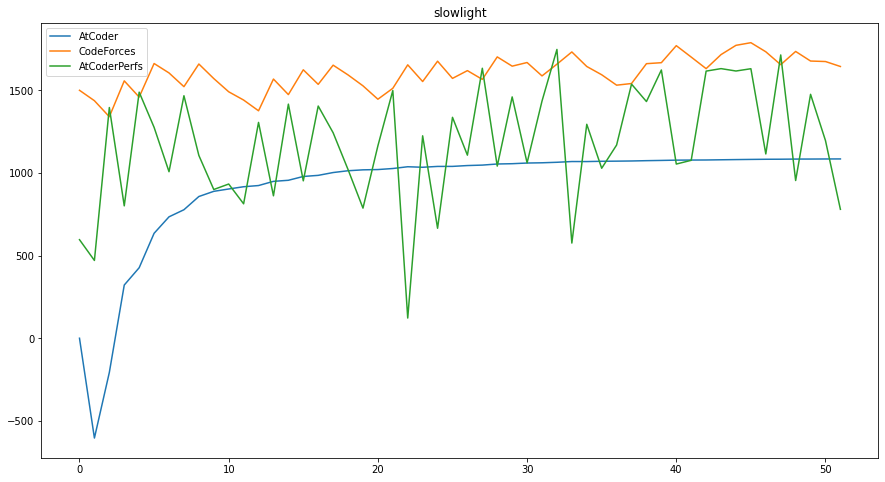

In [29]:
handle = getRandomUser(threshold=50)
compareSystems(handle)